# Caderno 4 - Calcula métricas considerando os resultados de pesquisa em um BM25 padrão

In [1]:
# Se True, refaz a indexação. Se False, tenta recuperar o
# índice do arquivo indice_js_enunciado_e_excerto.pickle.
# É necessário que esse arquivo exista.
REINDEXAR_ENUNCIADO_EXCERTO = False

PASTA_DADOS = './dados/'
PASTA_RESULTADO_CADERNO = f'{PASTA_DADOS}outputs/4_metricas_bm25_padrao/'
NOME_ARQUIVO_INDICE_ENUNCIADO_E_EXCERTO = f'{PASTA_RESULTADO_CADERNO}indice_js_enunciado_e_excerto.pickle'

## 1. Carrega base de dados

Carrega a lista de documentos para indexar, as queries para testar e o qrels.

In [2]:
import pandas as pd

# A pasta dos JURIS aqui não é a pasta original, e sim o resultado do caderno 1 (os documentos já estão filtrados)
PASTA_JURIS_TCU = f'{PASTA_DADOS}outputs/1_tratamento_juris_tcu/'

# Carrega os arquivos 
def carrega_juris_tcu():
    doc1 = pd.read_csv(f'{PASTA_JURIS_TCU}doc_tratado_parte_1.csv', sep='|')
    doc2 = pd.read_csv(f'{PASTA_JURIS_TCU}doc_tratado_parte_2.csv', sep='|')
    doc3 = pd.read_csv(f'{PASTA_JURIS_TCU}doc_tratado_parte_3.csv', sep='|')
    doc4 = pd.read_csv(f'{PASTA_JURIS_TCU}doc_tratado_parte_4.csv', sep='|')
    doc = pd.concat([doc1, doc2, doc3, doc4], ignore_index=True)
    query = pd.read_csv(f'{PASTA_JURIS_TCU}query_tratado.csv', sep='|')
    qrel = pd.read_csv(f'{PASTA_JURIS_TCU}qrel_tratado.csv', sep='|')

    return doc, query, qrel

docs, queries, qrels = carrega_juris_tcu()

## 2. Instancia um BM25 e indexa os campos ENUNCIADO e EXCERTO

In [3]:
from bm25 import IndiceInvertido, BM25, tokenizador_pt_remove_html

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\santosr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\santosr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\santosr\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


In [4]:
import os

# Vamos criar um índice invertido e indexar apenas o enunciado e excerto.
iidx = IndiceInvertido(tokenizador_pt_remove_html)

if REINDEXAR_ENUNCIADO_EXCERTO or not os.path.exists(NOME_ARQUIVO_INDICE_ENUNCIADO_E_EXCERTO):
    # Se for indexar a primeira vez:
    # Demora cerca de 35 minutos para indexar
    iidx.adiciona_dataframe(docs, lambda row: (row['KEY'], row['ENUNCIADO'] + ' ' + row['EXCERTO']))
    iidx.to_pickle(NOME_ARQUIVO_INDICE_ENUNCIADO_E_EXCERTO)
else:
    # Se quiser recuperar de um arquivo:
    iidx.from_pickle(NOME_ARQUIVO_INDICE_ENUNCIADO_E_EXCERTO)

In [5]:
print(iidx.get_tamanho_medio_docs())

476.4924275475226


In [6]:
# Agora instancia um BM25
buscador = BM25(iidx, k1=0.82, b=0.68, bias_idf=1)

## 3. Faz as pesquisas e salva os resultados

In [7]:
col_resultado_query_key=[]
col_resultado_doc_key=[]
col_resultado_rank=[]

for i, row in queries.iterrows():
    query_key = row.KEY
    query_text = row.TEXT
    resultados = buscador.pesquisar(query_text)

    primeiros_50_docs = [tupla_key_score[0] for tupla_key_score in resultados[:50]]
    queries_keys = [query_key] * len(primeiros_50_docs)
    ranking = list(range(1, len(primeiros_50_docs)+1))

    col_resultado_query_key.extend(queries_keys)
    col_resultado_doc_key.extend(primeiros_50_docs)
    col_resultado_rank.extend(ranking)

df_resultados = pd.DataFrame({
    "QUERY_KEY": col_resultado_query_key,
    "DOC_KEY": col_resultado_doc_key,
    "RANK": col_resultado_rank,
})

In [8]:
from metricas import metricas

df_metricas = metricas(df_resultados, qrels, aproximacao_trec_eval=True)

In [11]:
import pickle

# Gravando lote em um arquivo .pickle
caminho_arquivo_metricas = f'{PASTA_RESULTADO_CADERNO}metricas_bm25.pickle'
with open(caminho_arquivo_metricas, 'wb') as arquivo_pickle:
    pickle.dump(df_metricas, arquivo_pickle)

,QUERY_KEY,P@5,P@10,P@20,P@50,R@5,R@10,R@20,R@50,MRR@5,MRR@10,MRR@20,MRR@50,nDCG@5,nDCG@10,nDCG@20,nDCG@50
count,50.00000,50.00000,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,25.50000,0.26800,0.24400,0.206000,0.121200,0.107464,0.202369,0.342072,0.498814,0.528667,0.540690,0.545297,0.548477,0.284836,0.279956,0.349423,0.425649
std,14.57738,0.23771,0.18753,0.127631,0.056048,0.092887,0.163898,0.224214,0.257742,0.430709,0.416991,0.411274,0.407068,0.248851,0.222850,0.228603,0.226812
min,1.00000,0.00000,0.00000,0.000000,0.020000,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.022222,0.000000,0.000000,0.000000,0.027685
25%,13.25000,0.05000,0.10000,0.100000,0.065000,0.016667,0.071429,0.157051,0.254167,0.050000,0.157143,0.157143,0.157143,0.032801,0.088068,0.175104,0.231265
50%,25.50000,0.20000,0.20000,0.225000,0.120000,0.083333,0.174242,0.360390,0.480769,0.500000,0.500000,0.500000,0.500000,0.232573,0.241639,0.336855,0.434686
75%,37.75000,0.40000,0.40000,0.250000,0.160000,0.163462,0.305769,0.459790,0.698077,1.000000,1.000000,1.000000,1.000000,0.470365,0.432569,0.490675,0.608838
max,50.00000,1.00000,0.70000,0.500000,0.200000,0.384615,0.571429,0.818182,0.909091,1.000000,1.000000,1.000000,1.000000,0.991365,0.827036,0.806507,0.806507


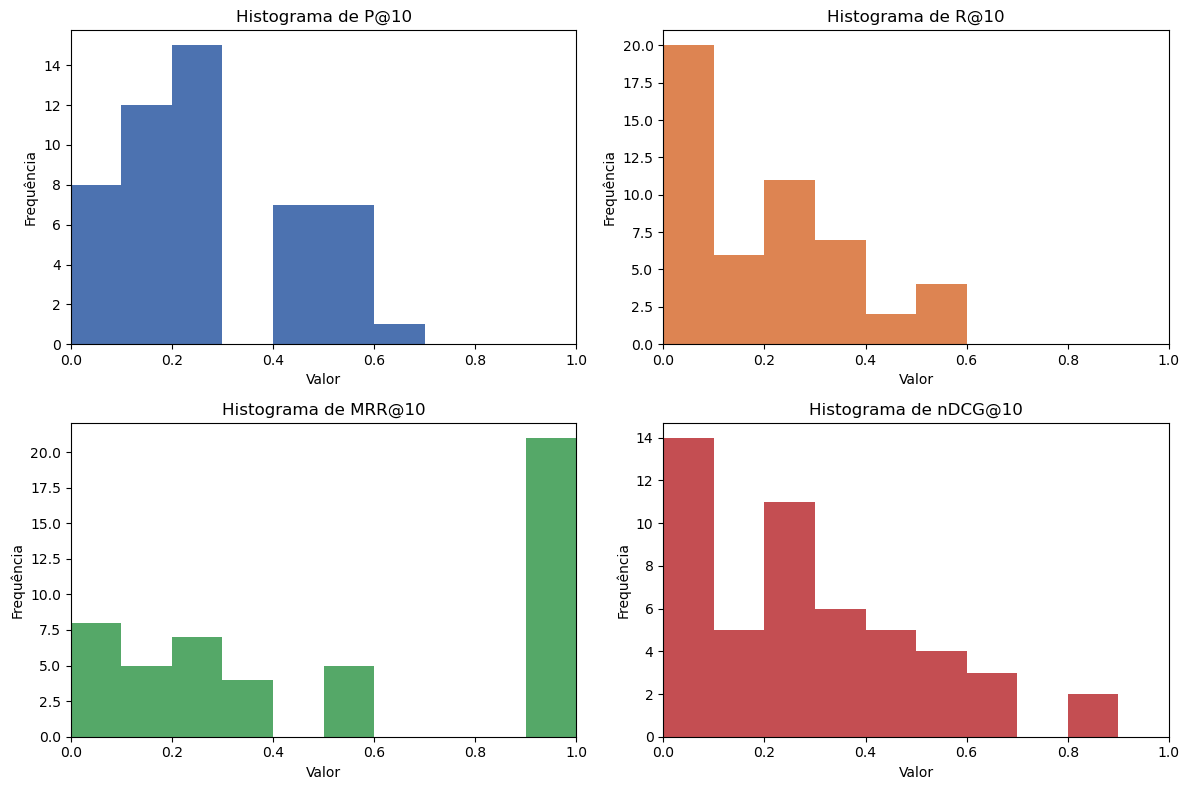

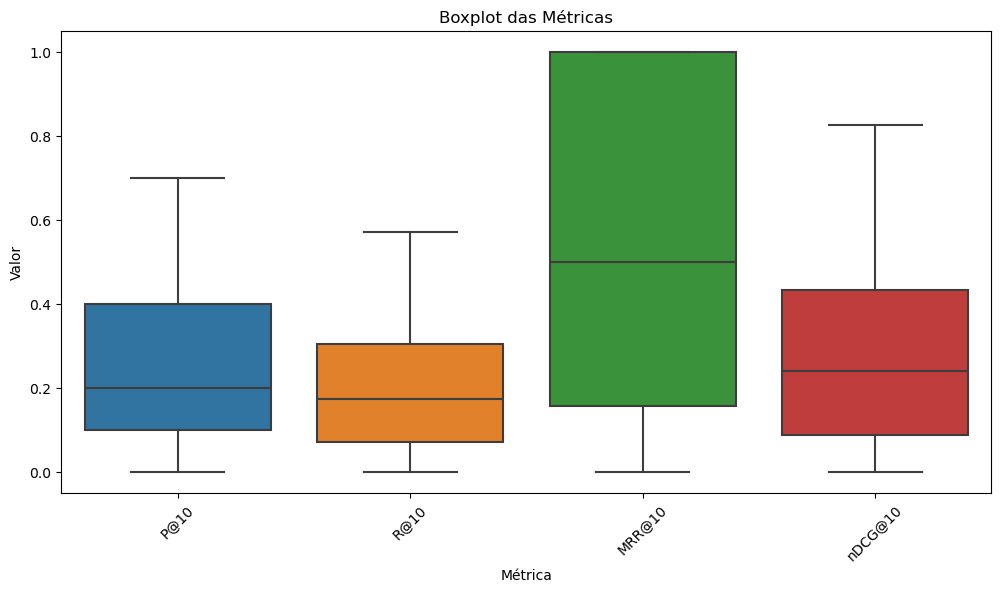

In [9]:
from metricas import histograma_metricas, boxplot_metricas

# Resultados para o primeiro grupo de queries:
display(df_metricas[0:50].describe())
histograma_metricas(df_metricas[0:50])
boxplot_metricas(df_metricas[0:50])

,QUERY_KEY,P@5,P@10,P@20,P@50,R@5,R@10,R@20,R@50,MRR@5,MRR@10,MRR@20,MRR@50,nDCG@5,nDCG@10,nDCG@20,nDCG@50
count,50.00000,50.000000,50.000000,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,75.50000,0.516000,0.376000,0.25900,0.139200,0.217037,0.316463,0.434099,0.580382,0.880000,0.887556,0.887556,0.887556,0.591321,0.517558,0.557133,0.622518
std,14.57738,0.268298,0.193317,0.12685,0.049315,0.117627,0.175659,0.230007,0.223121,0.291197,0.268685,0.268685,0.268685,0.240953,0.189324,0.200083,0.180429
min,51.00000,0.000000,0.100000,0.05000,0.020000,0.000000,0.071429,0.076923,0.083333,0.000000,0.100000,0.100000,0.100000,0.000000,0.051685,0.093803,0.122265
25%,63.25000,0.400000,0.200000,0.15000,0.105000,0.145604,0.224359,0.255682,0.436813,1.000000,1.000000,1.000000,1.000000,0.479415,0.388576,0.427069,0.535822
50%,75.50000,0.500000,0.400000,0.25000,0.150000,0.218254,0.285714,0.422619,0.591667,1.000000,1.000000,1.000000,1.000000,0.645588,0.558949,0.582133,0.646256
75%,87.75000,0.800000,0.500000,0.35000,0.180000,0.307692,0.425595,0.573864,0.750000,1.000000,1.000000,1.000000,1.000000,0.738061,0.638498,0.656981,0.714862
max,100.00000,1.000000,0.700000,0.50000,0.200000,0.454545,0.700000,0.900000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.832815,0.910426,0.939701


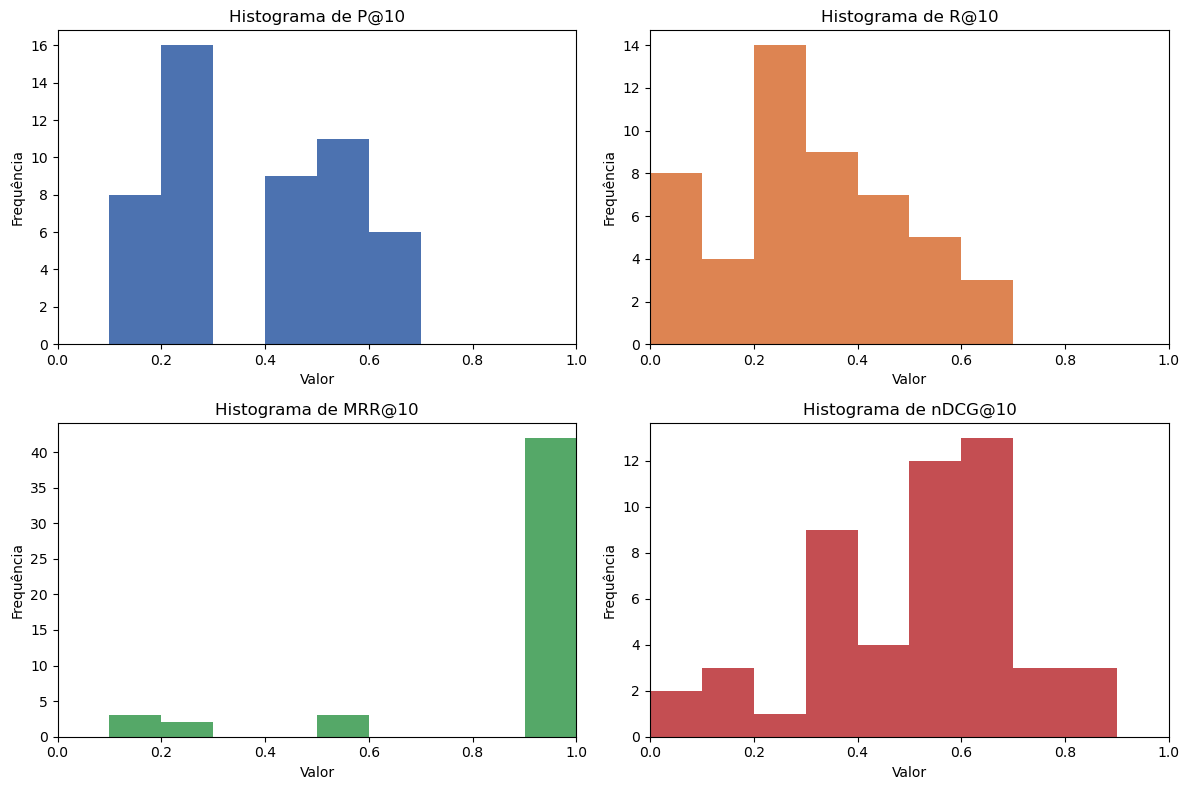

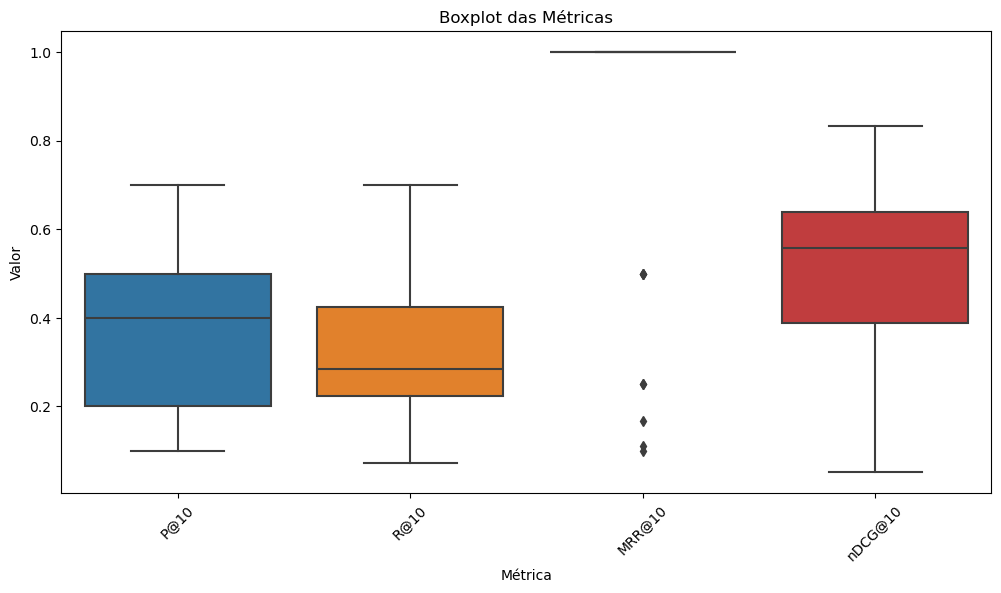

In [10]:
# Resultados para o primeiro grupo de queries:
display(df_metricas[50:100].describe())
histograma_metricas(df_metricas[50:100])
boxplot_metricas(df_metricas[50:100])

,QUERY_KEY,P@5,P@10,P@20,P@50,R@5,R@10,R@20,R@50,MRR@5,MRR@10,MRR@20,MRR@50,nDCG@5,nDCG@10,nDCG@20,nDCG@50
count,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,125.50000,0.520000,0.370000,0.259000,0.136400,0.233685,0.329400,0.458564,0.600717,0.911667,0.913889,0.913889,0.913889,0.602306,0.519349,0.574273,0.632016
std,14.57738,0.245781,0.178714,0.126447,0.053098,0.118177,0.160057,0.223200,0.231902,0.231093,0.222523,0.222523,0.222523,0.208798,0.172465,0.185761,0.172043
min,101.00000,0.000000,0.100000,0.050000,0.020000,0.000000,0.066667,0.066667,0.100000,0.000000,0.111111,0.111111,0.111111,0.000000,0.070969,0.193233,0.269553
25%,113.25000,0.400000,0.200000,0.150000,0.100000,0.166667,0.207692,0.300000,0.456294,1.000000,1.000000,1.000000,1.000000,0.497633,0.432999,0.453530,0.488973
50%,125.50000,0.600000,0.400000,0.250000,0.140000,0.226496,0.333333,0.480769,0.625874,1.000000,1.000000,1.000000,1.000000,0.602266,0.515814,0.590742,0.671751
75%,137.75000,0.600000,0.500000,0.350000,0.180000,0.300000,0.454545,0.583333,0.750000,1.000000,1.000000,1.000000,1.000000,0.737082,0.661128,0.715138,0.779286
max,150.00000,1.000000,0.700000,0.500000,0.220000,0.500000,0.636364,0.909091,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.801233,0.927799,0.927799


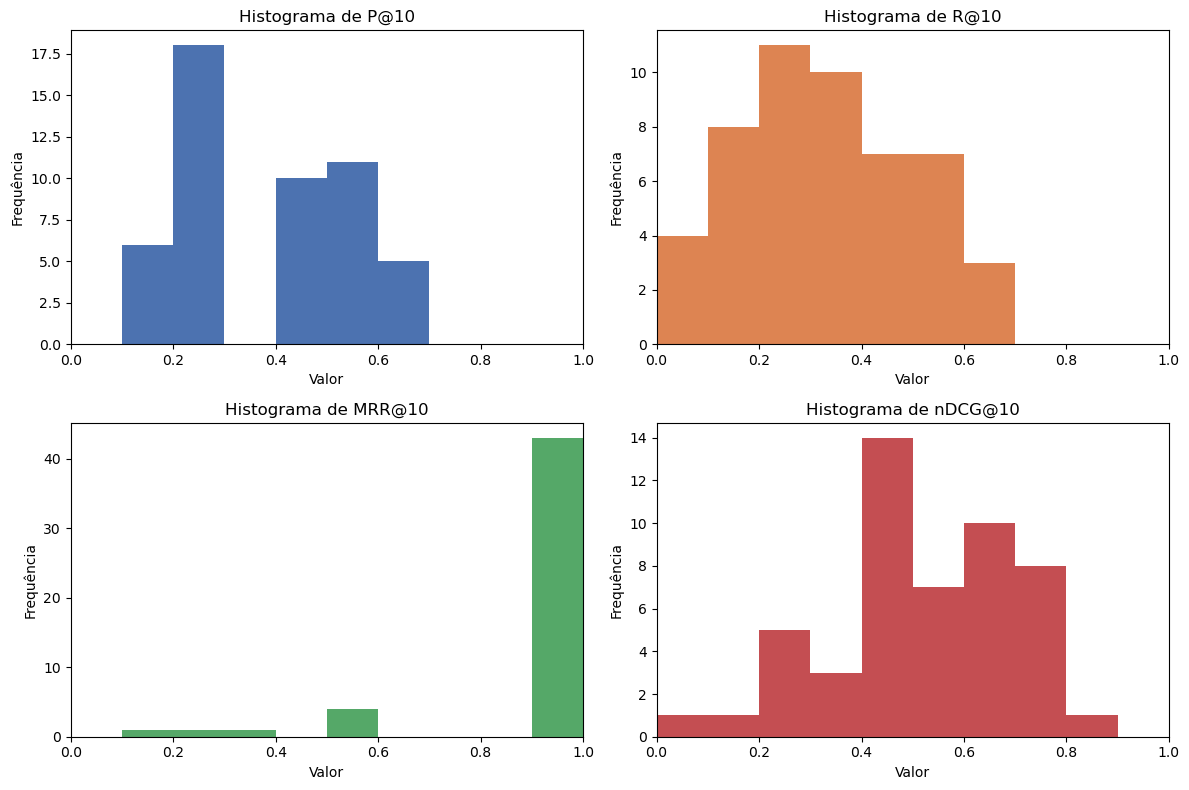

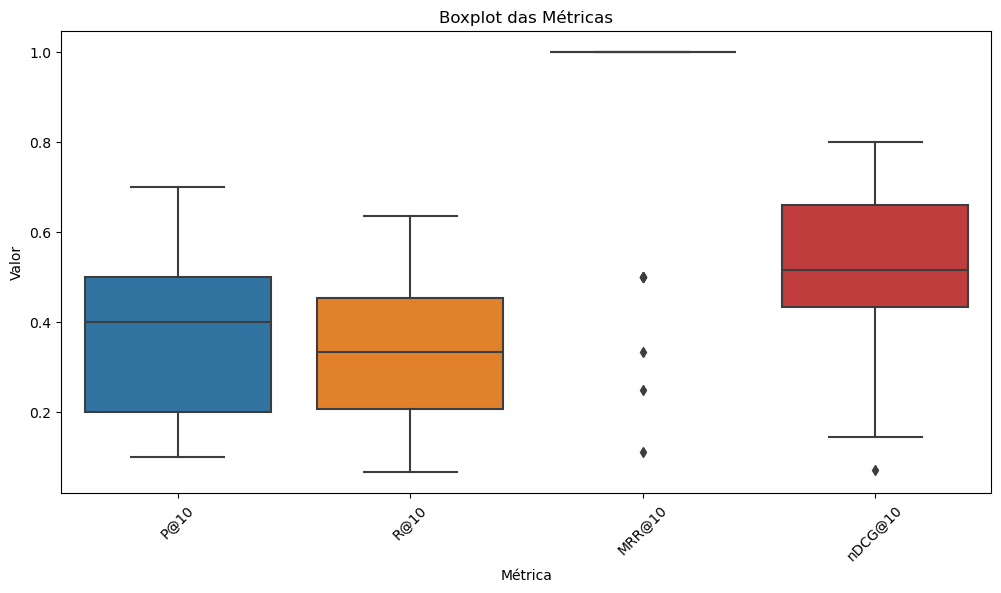

In [11]:
# Resultados para o primeiro grupo de queries:
display(df_metricas[100:150].describe())
histograma_metricas(df_metricas[100:150])
boxplot_metricas(df_metricas[100:150])